## yfinance Library Demo

### Disclaimers:

Trading stocks has it's own inherent risks. Trade at your own discretion. 
<br />

The predictions from the model is best thought of as correlations rather than causations.  

### Overview:

This notebook provides a random forest classifier model that predicts the direction of movement of a secruity in the next time interval.
<br />

The prediction is only for directions up 1 or down 0. 

### Imports: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = (8, 7)
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score
                             , precision_score
                             , recall_score
                             , roc_curve
                             , confusion_matrix
                             , plot_confusion_matrix
                             , precision_recall_curve
                             , auc
                            )

### Global Variables:

In [2]:
# yfinance automatically pull data up to the current time, unless specified 

# month = '06' # month and date not necessary if using fix period, see next cell
# date = '15'

# sf_hour = 13 # 6 to 13 military time in PST
# ny_hour = 4 # 9 to 16 military time in EST

# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
interval = '60m'

# time span of data e.g. 2y for 60m, 10y for 1d
period = '2y'

perc_inc = 0.01 # 1 percent increase from hour to hour or any time period

# start = '2018-07-01'

# end = '2020-' + month + '-' + date

symbol = 'VGT' # ITOT iShares TOTAL Market ETF stock

perc_train = 0.25 # percent of train set

### Yahoo Finance

In [3]:
stock_df = yf.download(tickers = symbol # symbol of stock 
                       
                       , period = period
                       
                       , interval = interval # time periods of subinterval e.g. 1m or 1hr
                       
                       # , start = start # start date, time
                       
                       # , end = end # end date, time
                       
                       , prepost = True # pre/post market data
                      )

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2018-06-19 10:30:00-04:00,185.600006,186.959900,185.529999,186.910004,186.910004,0
2018-06-19 11:30:00-04:00,187.039200,187.309998,186.800003,187.149902,187.149902,51175
2018-06-19 12:30:00-04:00,187.080002,187.189896,186.889999,187.059998,187.059998,36429
2018-06-19 13:30:00-04:00,186.949997,187.787399,186.949997,187.680099,187.680099,59515
2018-06-19 14:30:00-04:00,187.753006,187.953293,187.487503,187.487503,187.487503,50534


### EDA of Secruity

In [5]:
stock_df['percent change'] = (stock_df.Open - stock_df.Close) / stock_df.Open
stock_df.head()

,Open,High,Low,Close,Adj Close,Volume,percent change
Datetime,,,,,,,
2018-06-19 10:30:00-04:00,185.600006,186.959900,185.529999,186.910004,186.910004,0,-0.007058
2018-06-19 11:30:00-04:00,187.039200,187.309998,186.800003,187.149902,187.149902,51175,-0.000592
2018-06-19 12:30:00-04:00,187.080002,187.189896,186.889999,187.059998,187.059998,36429,0.000107
2018-06-19 13:30:00-04:00,186.949997,187.787399,186.949997,187.680099,187.680099,59515,-0.003905
2018-06-19 14:30:00-04:00,187.753006,187.953293,187.487503,187.487503,187.487503,50534,0.001414


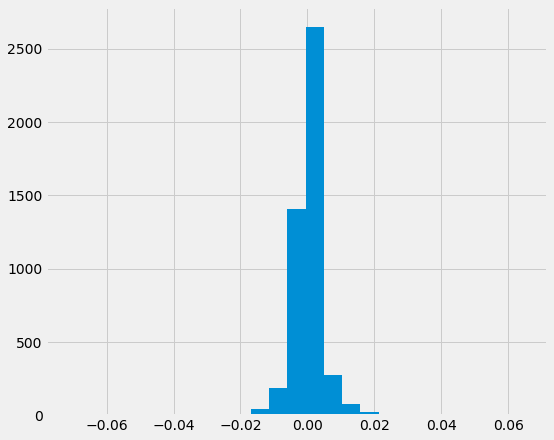

In [6]:
stock_df['percent change'].hist(bins=25);

In [7]:
stock_df['percent change'].quantile([0.84])

0.84    0.002476
Name: percent change, dtype: float64

### Assign Descisions for Up %+ or Not

In [8]:
stock_df['decision'] = np.where((stock_df['Close'] - stock_df['Open'])/stock_df['Open'] > perc_inc
                                
                                , 1  # 1 if up % or greater
                                
                                , 0  # 0 if not up % or greater
                                
                               )

In [9]:
stock_df.tail(15)

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Datetime,,,,,,,,
2020-06-17 16:00:00-04:00,272.910000,273.500000,272.900000,273.500000,273.500000,0,-0.002162,0
2020-06-18 09:30:00-04:00,272.619995,274.040009,272.010010,273.029999,273.029999,99568,-0.001504,0
2020-06-18 10:30:00-04:00,273.089996,274.670013,272.459991,274.269989,274.269989,74286,-0.004321,0
2020-06-18 11:30:00-04:00,274.220001,274.246185,273.020111,273.644989,273.644989,62028,0.002097,0
2020-06-18 12:30:00-04:00,273.700012,273.940613,273.350006,273.790009,273.790009,93369,-0.000329,0
2020-06-18 13:30:00-04:00,273.720001,274.279999,273.250000,273.600006,273.600006,99289,0.000438,0
2020-06-18 14:30:00-04:00,273.559998,274.000000,272.670013,273.380005,273.380005,139671,0.000658,0
2020-06-18 15:30:00-04:00,273.429993,274.579987,273.230011,274.559998,274.559998,95222,-0.004133,0
2020-06-18 16:00:00-04:00,274.400000,274.400000,274.400000,274.400000,274.400000,0,0.000000,0


### Create One Offs

Move decision column up by 1 row so the current
hour of data will predict the next hour of data
or whichever time frame is observed

In [10]:
decisions = stock_df.decision.values
type(decisions)

numpy.ndarray

In [11]:
len(decisions)

4711

In [12]:
decisions = decisions[1:len(decisions)] # from rows 2 to 6061

In [13]:
len(decisions)

4710

In [14]:
stock_df_one_off = stock_df.iloc[0:stock_df.shape[0]-1] # from rows 1 to 6060
stock_df_one_off.shape

(4710, 8)

In [15]:
stock_df_one_off.iloc[-1]

Open                277.299988
High                277.390015
Low                 276.454987
Close               276.750000
Adj Close           276.750000
Volume            35525.000000
percent change        0.001983
decision              0.000000
Name: 2020-06-19 10:30:00-04:00, dtype: float64

In [16]:
stock_df_one_off['decision'] = decisions
stock_df_one_off.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
Datetime,,,,,,,,
2018-06-19 10:30:00-04:00,185.600006,186.959900,185.529999,186.910004,186.910004,0,-0.007058,0
2018-06-19 11:30:00-04:00,187.039200,187.309998,186.800003,187.149902,187.149902,51175,-0.000592,0
2018-06-19 12:30:00-04:00,187.080002,187.189896,186.889999,187.059998,187.059998,36429,0.000107,0
2018-06-19 13:30:00-04:00,186.949997,187.787399,186.949997,187.680099,187.680099,59515,-0.003905,0
2018-06-19 14:30:00-04:00,187.753006,187.953293,187.487503,187.487503,187.487503,50534,0.001414,0


In [17]:
stock_df_one_off.decision.value_counts() # there is an inablance between 0's and 1's

0    4604
1     106
Name: decision, dtype: int64

### Balance the 0's and 1's

In [18]:
ones = stock_df_one_off.decision.value_counts()[1]
ones

106

In [19]:
stock_df_bal = stock_df_one_off.groupby('decision').apply(lambda x: x.sample(n=ones)).reset_index(drop=True)

In [20]:
stock_df_bal.shape

(212, 8)

In [21]:
stock_df_bal.decision.value_counts()

1    106
0    106
Name: decision, dtype: int64

### Check for NaN's

In [22]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

In [23]:
stock_df_bal.dropna(axis=0, inplace=True)

In [24]:
stock_df_bal.isna().sum()

Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
percent change    0
decision          0
dtype: int64

### Train Test Split

In [25]:
X = stock_df_bal.drop(columns=['percent change', 'decision']) # get columns other than decision
y = stock_df_bal['decision'] # get decision column

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X
                                                    , y
                                                    , test_size=0.20
                                                    , random_state = 42
                                                   )

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(n_estimators = int(perc_train * len(X_train)) # odd number 
                             , random_state = 42
                             , verbose=1
                             , n_jobs = -1 # access all of your processor cores Lenovo P50 i7-6820HQ 2.7GHz
                            )

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

y_probs = rfc.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:    0.0s finished


### Measures of Performances: Receiver Operating Characteristic (ROC) Curve

In [28]:
roc_value = roc_auc_score(y_test
                          , y_probs
                         )
roc_value

0.7675438596491229

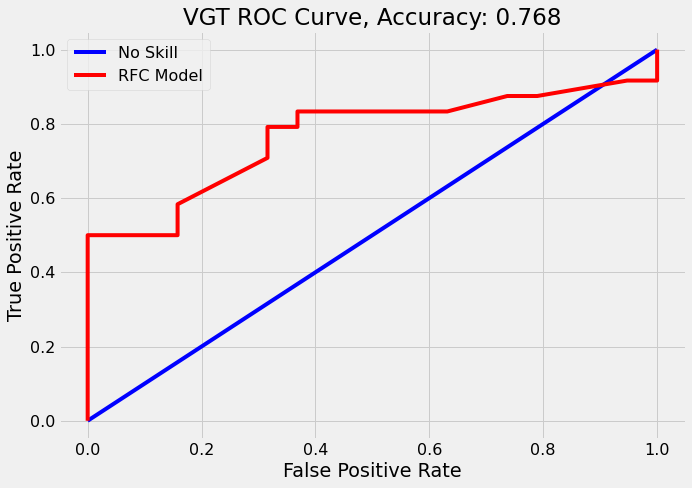

In [29]:
plt.rcParams['font.size'] = 16
base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
model_fpr, model_tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(10,7))
plt.plot(base_fpr, base_tpr, 'b', label='No Skill')
plt.plot(model_fpr, model_tpr, 'r', label='RFC Model')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'{symbol} ROC Curve, Accuracy: {round(roc_value, 3)}');

### Measures of Performance: Confusion Matrix

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:    0.0s finished


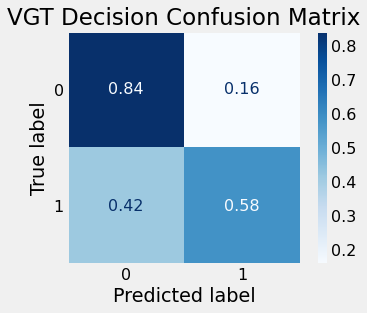

In [30]:
plt.rcParams['figure.figsize'] = (5, 4)
plt.rcParams['font.size'] = 16
disp = plot_confusion_matrix(rfc
                           , X_test
                           , y_test
                           , cmap=plt.cm.Blues
                           , normalize='true'
                     )
disp.ax_.grid(False)
disp.ax_.set_title(f'{symbol} Decision Confusion Matrix');

### Measures of Performance: Precision Recall Curve

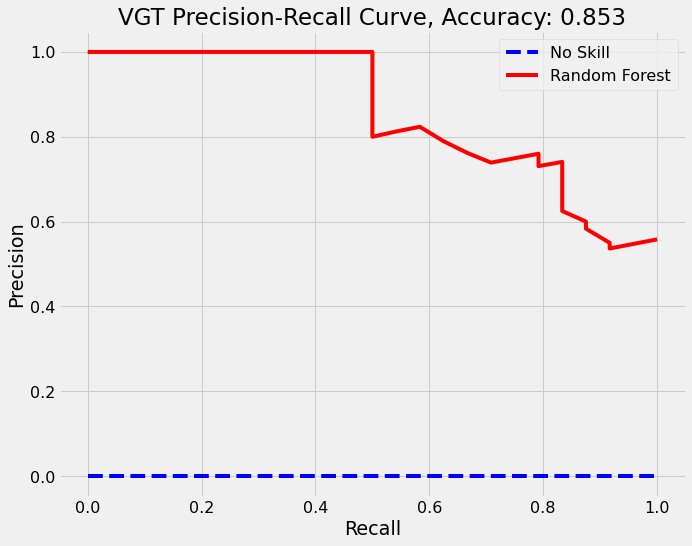

In [31]:
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (10,8)
rf_prec, rf_recall, _ = precision_recall_curve(y_test, y_probs)
plt.plot([0, 0], linestyle = '--', color = 'b', label='No Skill')
plt.plot(rf_recall, rf_prec, color='r', label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title(f'{symbol} Precision-Recall Curve, Accuracy: {round(auc(rf_recall, rf_prec), 3)}');

### Measure of Performance: Feature Importances

In [32]:
feature_df = pd.DataFrame({'feature': X_train.columns
                           , 'importances': rfc.feature_importances_
                          }).sort_values('importances', ascending=False)
feature_df

,feature,importances
5,Volume,0.317904
0,Open,0.148568
1,High,0.146766
3,Close,0.136393
2,Low,0.131742
4,Adj Close,0.118628


In [33]:
stock_df_bal.head()

,Open,High,Low,Close,Adj Close,Volume,percent change,decision
0,173.440002,174.039993,173.425003,173.809998,173.809998,74053,-0.002133,0
1,259.500000,259.750000,259.500000,259.750000,259.750000,0,-0.000963,0
2,184.200000,184.200000,182.400000,182.500000,182.500000,0,0.009229,0
3,209.949997,210.220001,209.389999,209.462906,209.462906,48205,0.002320,0
4,203.544098,203.750000,203.399994,203.589996,203.589996,46927,-0.000225,0


### Make A Prediction

In [34]:
last = stock_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].iloc[-1]
last

Open         276.809998
High         276.809998
Low          276.809998
Close        276.809998
Adj Close    276.809998
Volume         0.000000
Name: 2020-06-19 11:03:22-04:00, dtype: float64

In [35]:
if rfc.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {symbol} on the {interval} interval for {round(perc_inc *100, 1)}% increase.')
else:
    print(f'Sell or hold {symbol} on the {interval} interval.')

Sell or hold VGT on the 60m interval.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  42 out of  42 | elapsed:    0.0s finished


# 